In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
# Clearing the environment

try:
    del data_dir, file_paths, labels, class_names, data_df, label_map, inverse_label_map, train_df, test_df, processor, model, train_dataset, test_dataset
except NameError:
    print("Some are non-existent!")

!rm -rf /kaggle/working/*
%reset -f


import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Some are non-existent!
Memory has been reset


In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '/kaggle/input/cwt-of-soil-moisture-from-cw-radar-signals/'

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Walk through all subfolders and files
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        file_paths.append(os.path.join(subdir, file))
        labels.append(os.path.basename(subdir))

# Create a DataFrame
data_df = pd.DataFrame({'file_path': file_paths, 'label': labels})
data_df = data_df.sort_values(by='label', ascending=True)

# Display the DataFrame
print(data_df.head())
print(data_df.label.value_counts())

                                              file_path label
0     /kaggle/input/cwt-of-soil-moisture-from-cw-rad...   Dry
5768  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...   Dry
5767  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...   Dry
5766  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...   Dry
5765  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...   Dry
label
Dry      8640
Moist    8640
Wet      8640
Name: count, dtype: int64


In [4]:
# convert labels to integers

label_map = {label: idx for idx, label in enumerate(data_df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
data_df['label'] = data_df['label'].map(label_map)
print(data_df.head())
print(data_df.tail())

                                              file_path  label
0     /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      0
5768  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      0
5767  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      0
5766  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      0
5765  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      0
                                               file_path  label
20151  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      2
20150  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      2
20149  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      2
20163  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      2
25919  /kaggle/input/cwt-of-soil-moisture-from-cw-rad...      2


In [5]:
class ImageClassificationDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor
        self.samples = self._prepare_samples()

    def _prepare_samples(self):
        samples = []
        for _, row in self.df.iterrows():
            image_path = row['file_path']
            label = row['label']
            try:
                image = Image.open(image_path)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
                continue

            samples.append({'image': image, 'label': label})
        return pd.DataFrame(samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        processed_image = self.samples.iloc[idx]['image']
        processed_label = int(self.samples.iloc[idx]['label'])
    
        inputs = self.processor(images=processed_image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
    
        return {'pixel_values': pixel_values, 'labels': torch.tensor(processed_label, dtype=torch.long)}

In [7]:
# Defining Logs

from transformers import Trainer, TrainingArguments, TrainerCallback

class PlottingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Collect metrics during training
        if "loss" in logs:
            self.train_losses.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_losses.append(logs["eval_loss"])
        if "eval_accuracy" in logs:
            self.eval_accuracies.append(logs["eval_accuracy"])
        if "train_accuracy" in logs:
            self.train_accuracies.append(logs["train_accuracy"])

# Initialize the callback
plotting_callback = PlottingCallback()

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 42)

In [9]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoFeatureExtractor, ViTImageProcessor, ViTForImageClassification, BeitImageProcessor, BeitForImageClassification, ViTHybridImageProcessor, ViTHybridForImageClassification

# for vit-base
# processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# for swinv2_tiny
# processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")
# model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")

# for beit-base
processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

# for deit-base
# processor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')

# for vit_hybrid_base_bit
# processor = ViTHybridImageProcessor.from_pretrained('google/vit-hybrid-base-bit-384')
# model = ViTHybridForImageClassification.from_pretrained('google/vit-hybrid-base-bit-384')

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/414M [00:00<?, ?B/s]

In [10]:
train_dataset = ImageClassificationDataset(train_df, processor)
test_dataset = ImageClassificationDataset(test_df, processor)

In [11]:
training_args = TrainingArguments(
    output_dir = './results',
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    learning_rate = 1e-5,
    lr_scheduler_type="linear",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 20,
    weight_decay = 0.01,
    report_to = []
)

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [13]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics,
    callbacks=[plotting_callback],
    tokenizer=processor
)

train_results = trainer.train()

trainer.save_model("./best_model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

eval_results = trainer.evaluate(test_dataset)
trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)
print(eval_results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.205500,0.463724,0.826775,0.830268,0.826775,0.825559
2,0.344200,0.358689,0.875579,0.878430,0.875579,0.875520
3,0.208700,0.386884,0.882523,0.891972,0.882523,0.882674
4,0.135500,0.493571,0.896798,0.900126,0.896798,0.896621
5,0.084500,0.498508,0.914545,0.914596,0.914545,0.914548
6,0.061600,0.665879,0.912423,0.914360,0.912423,0.912019
7,0.039000,0.751459,0.907986,0.908784,0.907986,0.907852
8,0.040700,0.889148,0.896219,0.900229,0.896219,0.896339
9,0.035700,0.943990,0.913194,0.916175,0.913194,0.912997
10,0.032800,0.814249,0.916860,0.916997,0.916860,0.916761


***** train metrics *****
  epoch                    =          20.0
  total_flos               = 35776016270GF
  train_loss               =        0.1161
  train_runtime            =    2:55:06.80
  train_samples_per_second =        39.472
  train_steps_per_second   =         2.467


***** eval metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9306
  eval_f1                 =     0.9305
  eval_loss               =     0.7716
  eval_precision          =     0.9306
  eval_recall             =     0.9306
  eval_runtime            = 0:00:43.85
  eval_samples_per_second =    118.214
  eval_steps_per_second   =      7.388
{'eval_loss': 0.771562933921814, 'eval_accuracy': 0.9305555555555556, 'eval_precision': 0.9305682750579414, 'eval_recall': 0.9305555555555556, 'eval_f1': 0.9305306017650149, 'eval_runtime': 43.8529, 'eval_samples_per_second': 118.214, 'eval_steps_per_second': 7.388, 'epoch': 20.0}


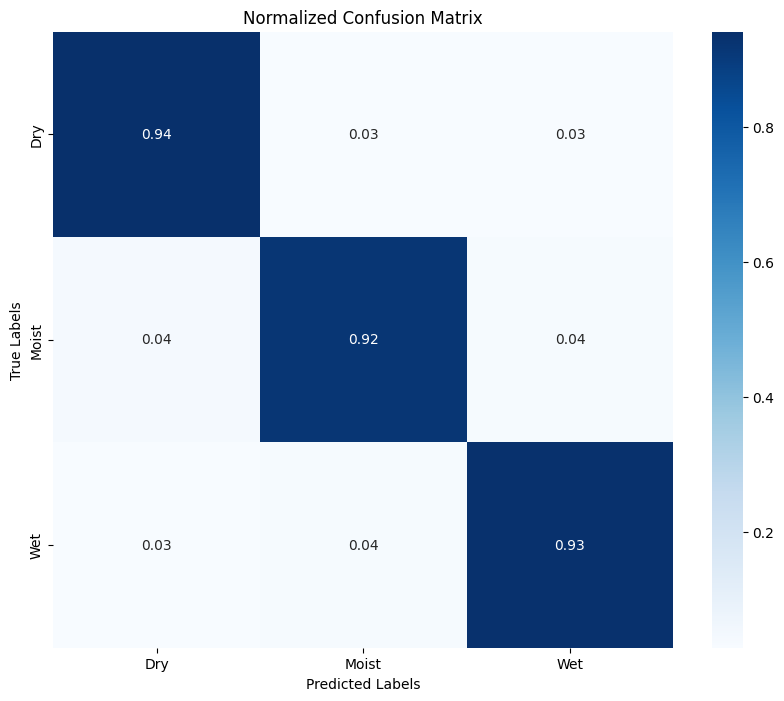

              precision    recall  f1-score   support

         Dry       0.93      0.94      0.93      1737
       Moist       0.93      0.92      0.92      1745
         Wet       0.93      0.93      0.93      1702

    accuracy                           0.93      5184
   macro avg       0.93      0.93      0.93      5184
weighted avg       0.93      0.93      0.93      5184



In [14]:
class_names = []

for idx in data_df['label'].unique():
    class_names.append(inverse_label_map[idx])

from sklearn.metrics import confusion_matrix, classification_report

true_labels, predicted_labels = [], []

for idx in range(len(test_dataset)):
    true_labels.append(inverse_label_map[int(test_dataset[idx]['labels'])])
    input_values = test_dataset[idx]['pixel_values'].unsqueeze(0).to('cuda')
    
    with torch.no_grad():
        outputs = model(input_values)
    logits = outputs.logits
    
    predicted_class = logits.argmax(dim = -1).item()
    predicted_labels.append(inverse_label_map[predicted_class])

cm = confusion_matrix(true_labels, predicted_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names))

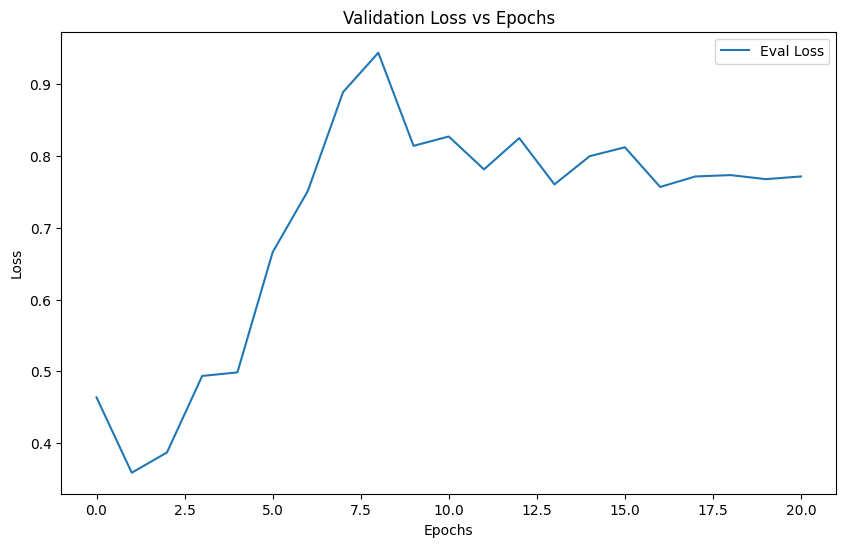

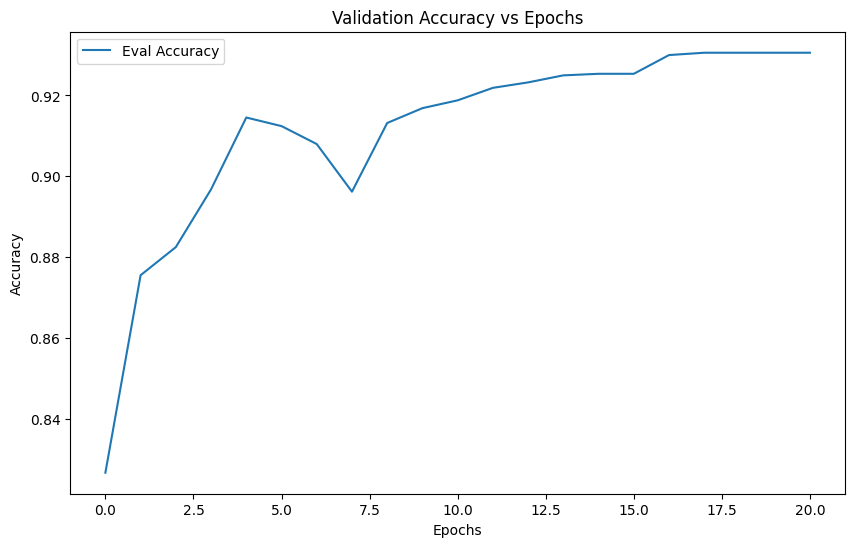

In [15]:
plt.figure(figsize=(10, 6))
# plt.plot(plotting_callback.train_losses, label='Train Loss')
plt.plot(plotting_callback.eval_losses, label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epochs')
plt.legend()
plt.savefig('Loss.png', dpi=1200)
plt.show()

# Plot train & test accuracy
plt.figure(figsize=(10, 6))
# plt.plot(plotting_callback.train_accuracies, label='Train Accuracy')
plt.plot(plotting_callback.eval_accuracies, label='Eval Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.savefig('Acc.png', dpi=1200)
plt.show()